In [1]:
from fastai.vision.all import *

Let's start with a simple, synthetic, example model. Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [17]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [7]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
speed

tensor([68.0076, 56.1707, 38.6200, 35.6072, 21.6621, 16.0951,  5.5928,  9.0282,
         6.8800, -0.9810, -5.6613,  6.4598,  6.1317,  8.8790, 18.2302, 25.5848,
        32.4670, 41.6560, 53.8866, 69.5841])

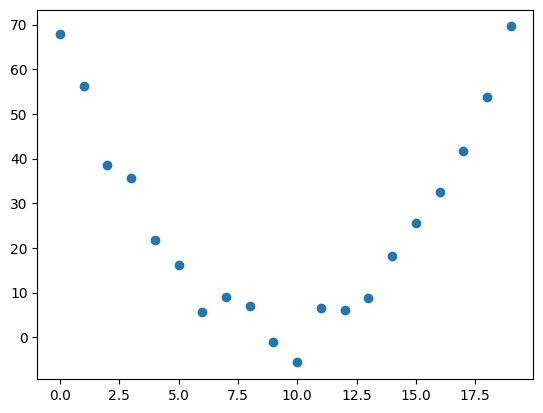

In [8]:
plt.scatter(time,speed)

We've added a bit of random noise, since measuring things manually isn't precise. This means it's not that easy to answer the question: what was the roller coaster's speed? Using SGD we can try to find a function that matches our observations. We can't consider every possible function, so let's use a guess that it will be quadratic; i.e., a function of the form a*(time**2)+(b*time)+c.

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define which quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, *t*(time), and the parameters, *params*, in the function's signature:

In [9]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In other words, we've restricted the problem of finding the best imaginable function that fits the data, to finding the best quadratic function. Thus, to find the best quadratic function, we only need to find the best values for *a*, *b*, and *c*.

If we can solve this problem for the three parameters of a quadratic function, we'll be able to apply the same approach for other, more complex functions with more parameters—such as a *neural net*.

We need to define first what we mean by "best." We define this precisely by choosing a `loss function`, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use *mean squared error*:

In [10]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters

First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using requires_grad_:

In [16]:
params = torch.randn(3).requires_grad_()
orig_params = params.clone()
params

tensor([-0.5639,  0.4815, -0.7795], requires_grad=True)

#### Step 2: Calculate the predictions

In [26]:
preds = f(time, params)
preds

tensor([  -0.7795,   -0.8620,   -2.0724,   -4.4106,   -7.8767,  -12.4708,
         -18.1927,  -25.0425,  -33.0202,  -42.1257,  -52.3592,  -63.7206,
         -76.2098,  -89.8269, -104.5720, -120.4449, -137.4457, -155.5744,
        -174.8309, -195.2154], grad_fn=<AddBackward0>)

Let's create a little function to see how close our `predictions` are to our `targets`, and take a look:

In [24]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

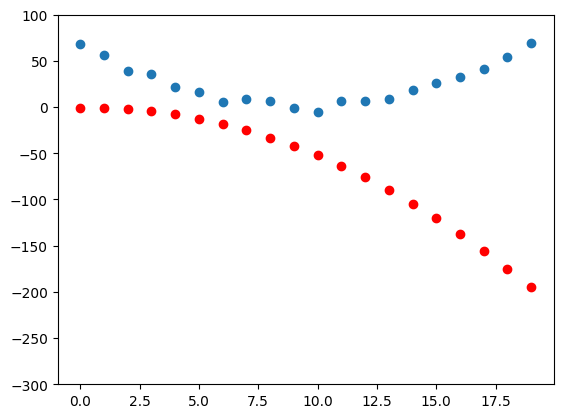

In [25]:
show_preds(preds)

This doesn't look very close—our random parameters suggest that the roller coaster will end up going backwards, since we have negative speeds!

#### Step 3: Calculate the loss

In [27]:
loss = mse(preds, speed)
loss

tensor(13408.8145, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we'll need to know the gradients.

#### Step 4: Calculate the gradients

The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [28]:
loss.backward()
params.grad

tensor([-37899.9141,  -2422.9707,   -183.0953])

In [29]:
params.grad * 1e-5

tensor([-0.3790, -0.0242, -0.0018])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [30]:
params

tensor([-0.5639,  0.4815, -0.7795], requires_grad=True)

#### Step 5: Step the weights/learning rate.

Now we need to update the parameters based on the gradients we just calculated:

In [31]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Let's see if the loss has improved:

In [35]:
preds = f(time,params)
mse(preds, speed)

tensor(3060.2107, grad_fn=<MeanBackward0>)

And take a look at the plot:

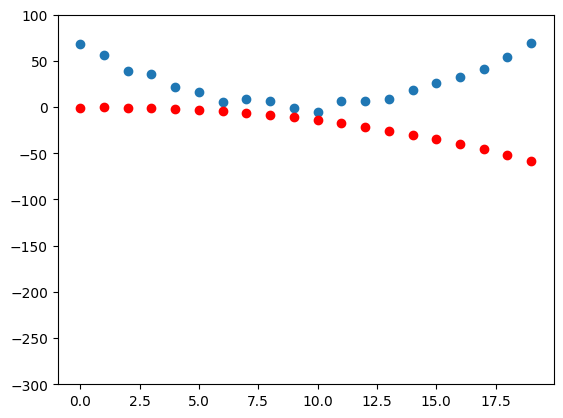

In [36]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step:

In [37]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process

Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [38]:
for i in range(10): apply_step(params)

3060.210693359375
1101.9365234375
731.3684692382812
661.2427368164062
647.9698486328125
645.4553833007812
644.9765014648438
644.8829345703125
644.8623046875
644.85546875


In [39]:
params = orig_params.detach().requires_grad_()

The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

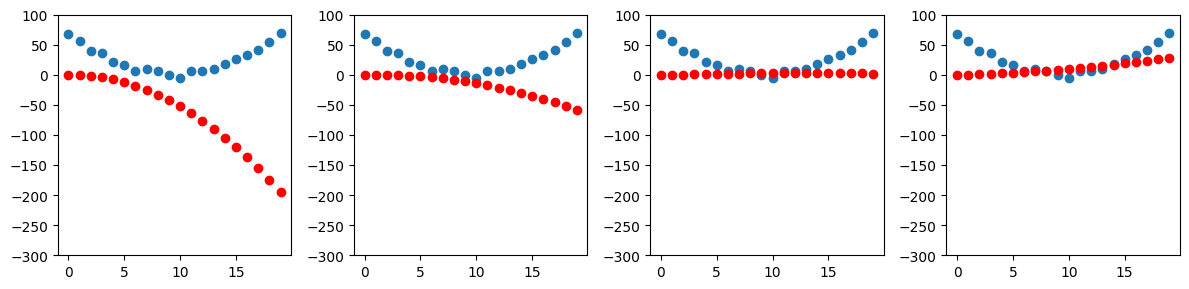

In [40]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.

Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the learning rate to decide on the step size. We then iterate until we have reached the lowest point, which will be our parking lot, then we can stop.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function.